# Boilerplate

In [1]:
from typing import Union
from allensdk.brain_observatory.ecephys.behavior_ecephys_session import BehaviorEcephysSession


from allensdk.brain_observatory.behavior.behavior_project_cache import (
    VisualBehaviorNeuropixelsProjectCache,
)
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from hmmlearn import hmm, vhmm
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler

import utils

import warnings
warnings.filterwarnings("ignore")

# Random seed
SEED = 42

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cache_dir = utils.get_data_root()
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
    cache_dir=cache_dir, use_static_cache=True
)

In [3]:
ephys_table = cache.get_ecephys_session_table()
ephys_table = ephys_table.loc[(~ephys_table["behavior_session_id"].isna()) & 
                              (ephys_table["experience_level"] == "Familiar")
                             ]

In [4]:
# session_id = 1124507277
# session_id = 1069461581
# session = cache.get_ecephys_session(session_id)
session_ids = np.random.choice(ephys_table.index, 20)

# Defining Behavioral Metrics

In [5]:
def align_to_stimulus(df: pd.DataFrame, session: BehaviorEcephysSession, active: bool = True) -> pd.DataFrame:
    if "timestamps" not in df.columns:
        raise ValueError("column timestamps must be present in df.")
    
    stim_presentations = session.stimulus_presentations
    if active:
        stim_presentations = stim_presentations.loc[stim_presentations["active"]]
    
    df = df.loc[(stim_presentations["start_time"].min() <= df["timestamps"]) 
                & (df["timestamps"] <= stim_presentations["end_time"].max())]
    bins = pd.concat([pd.Series([0]), stim_presentations["end_time"]])
    labels = stim_presentations.index
    stimulus_id_aligned = pd.cut(df["timestamps"], bins=bins, labels=labels, include_lowest=True, right=False)
    df = pd.concat([pd.Series(stimulus_id_aligned, name="stimulus_id"), df], axis=1)
    return df

In [205]:
def get_behavior_metrics(
    session: BehaviorEcephysSession, 
    center: bool = True,
) -> pd.DataFrame:
    eye = session.eye_tracking
    eye = eye.loc[(eye["likely_blink"] != True)]
    eye_metrics = eye[["timestamps", "pupil_area"]]
    eye_metrics = align_to_stimulus(eye_metrics, session)
    
    running_metrics = session.running_speed
    running_metrics = align_to_stimulus(running_metrics, session)


    rewards = (rewards := session.rewards).loc[~rewards["auto_rewarded"]]
    rewards_metric = align_to_stimulus(rewards, session)[["stimulus_id", "timestamps", "volume"]]
    rewards_metric["volume"] = rewards_metric["volume"].cumsum()
    
    metrics = (
        eye_metrics.
        merge(running_metrics, on="stimulus_id").
        groupby("stimulus_id").
        aggregate({"pupil_area": "mean", "speed": "mean"})
    )

    rolling_perf = session.get_rolling_performance_df()[["hit_rate"]]
    stimulus_presentations = session.stimulus_presentations
    metrics = (
        metrics.merge(stimulus_presentations["trials_id"], left_on="stimulus_id", right_index=True)
        .merge(rolling_perf, left_on="trials_id", right_index=True)
        .merge(rewards_metric[["stimulus_id", "volume"]], on="stimulus_id", how="left")
        .drop(columns=["trials_id", "stimulus_id"])
    )
    # Assign stimulus presentations that weren't rewarded to make volume a step function
    csum = metrics["volume"].notnull().cumsum()
    metrics["volume"] = metrics["volume"].fillna(0).groupby(csum).transform('sum')
    metrics = metrics.loc[(metrics.isna().sum(axis=1) == 0)]
    if center:
        metrics[["pupil_area", "speed"]] -= metrics[["pupil_area", "speed"]].mean(axis=0)
        metrics = metrics.loc[(metrics["pupil_area"] <= 3500)]
    
    metrics = metrics.loc[:, ~metrics.columns.str.startswith("timestamps")]
    return metrics

In [ ]:
%%time
parallel = False
if parallel:
    metrics = utils.parallel_session_map(get_behavior_metrics, session_ids, "ephys")
    metrics = [session[1] for session in metrics["sessions"]]
else:
    sessions = [cache.get_ecephys_session(session_id) for session_id in session_ids]
    metrics = [get_behavior_metrics(session, center=True) for session in sessions]

# HMM Model Fitting and Plotting

In [ ]:
startprob = np.array([1.00, 0.00])
transmat = np.array([[0.95, 0.05],
                     [0.01, 0.99]
                    ])
covars = np.ones((X.shape[1], X.shape[1])) * 0.5 
model_2 = hmm.GaussianHMM(
    n_components=2, 
    n_iter=100000, 
    random_state=SEED, 
    init_params="mc", 
    covariance_type="full", 
    startprob_prior=startprob,
    transmat_prior=transmat,
    covars_prior=X.cov().values + 250,
    algorithm="map",
    implementation="scaling"
)

In [ ]:
startprob = np.array([1.00, 0.00, 0.00,])
transmat = np.array([[0.98, 0.01, 0.01],
                      [0.01, 0.98, 0.01],
                      [0.01, 0.01, 0.98,],
                    ])
covars = np.ones((X.shape[1], X.shape[1])) * 0.5 
model_3 = hmm.GaussianHMM(
    n_components=3, 
    n_iter=100000, 
    random_state=SEED, 
    init_params="mc", 
    covariance_type="full", 
    startprob_prior=startprob,
    transmat_prior=transmat,
    covars_prior=X.cov().values + 500,
    algorithm="map",
    implementation="scaling",
)

In [ ]:
X = pd.concat(metrics)
X_lens = [len(x) for x in metrics]
model_2.fit(X, X_lens)
model_3.fit(X, X_lens);

In [ ]:
metric_idx = 0

In [ ]:
sns.pairplot(metrics[metric_idx], corner=True);

In [ ]:
m_result = metrics[metric_idx].copy()
m_result["state_2"] = model_2.predict(metrics[metric_idx])
m_result["state_3"] = model_3.predict(metrics[metric_idx])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16,6))
subfigs = fig.subfigures(nrows=1, ncols=2)
for col, subfig in enumerate(subfigs):
    state = col + 2
    subfig.suptitle(f"State transition ({state} states)")
    ax = subfig.subplots()
    ax.plot(np.arange(m_result.shape[0]),m_result[f"state_{state}"])
    ax.set_yticks(np.arange(state), labels=np.arange(state).astype(str))

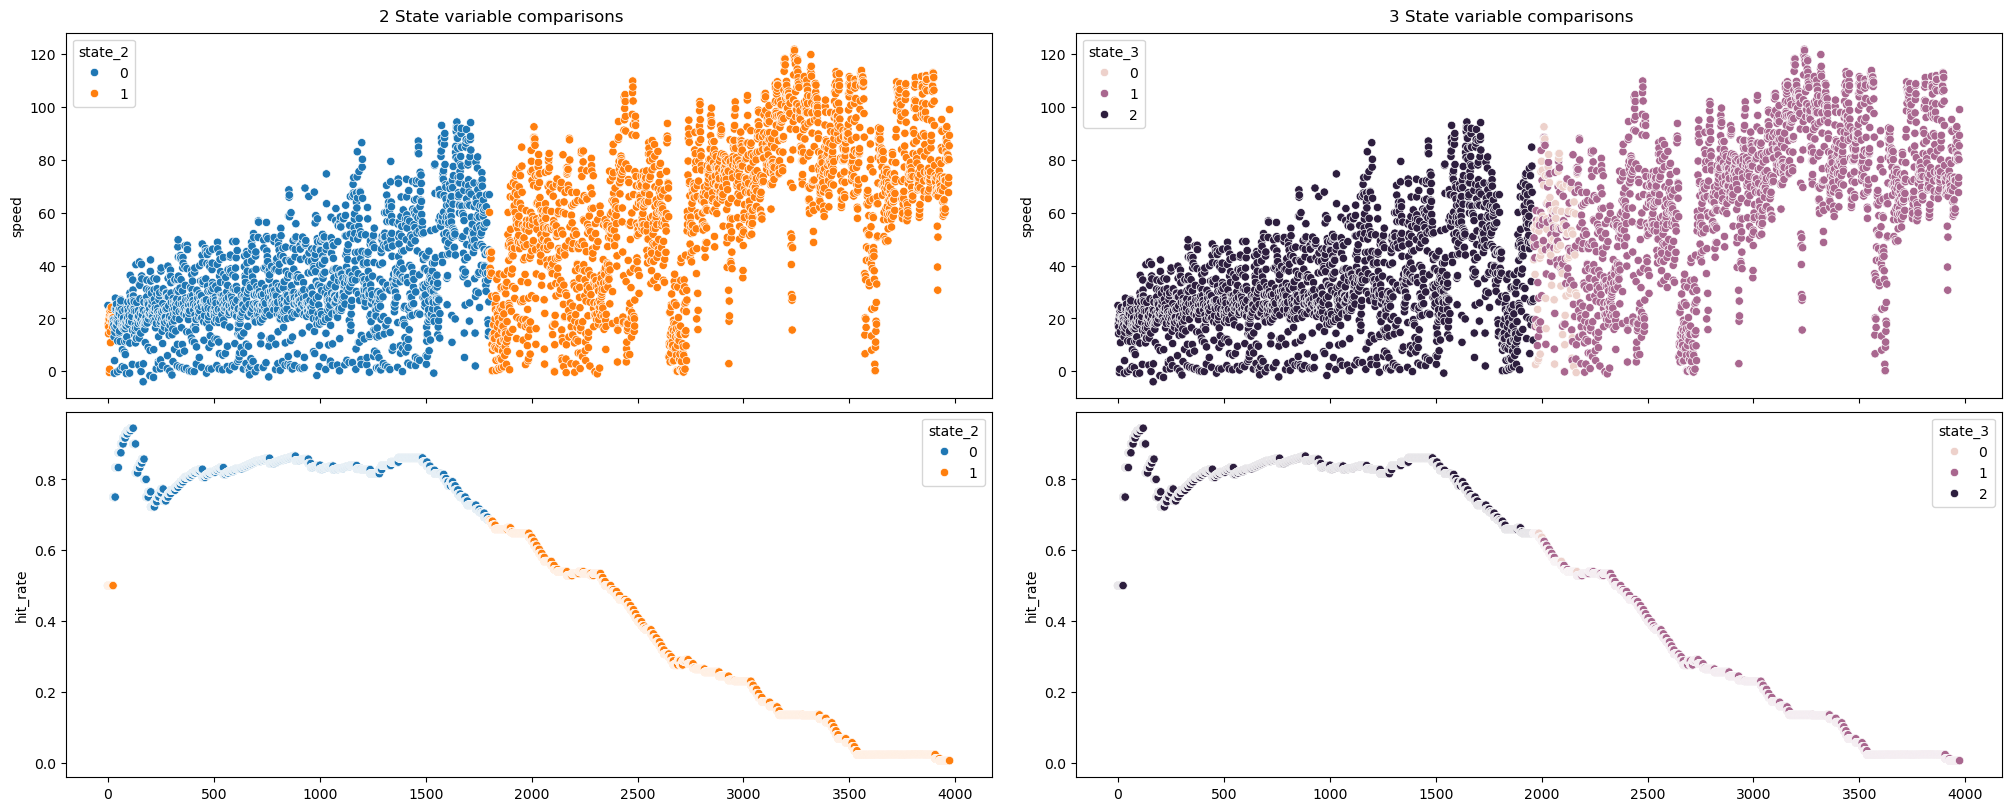

In [204]:
fig = plt.figure(constrained_layout=True, figsize=(20,8))
subfigs = fig.subfigures(nrows=1, ncols=2)
for row, subfig in enumerate(subfigs):
    state = row + 2
    subfig.suptitle(f"{state} State variable comparisons")
    axes = subfig.subplots(2, 1, sharex=True)
    sns.scatterplot(
        m_result,
        x=np.arange(m_result.shape[0]),
        y="speed",
        hue=m_result[f"state_{state}"], ax=axes[0])
    sns.scatterplot(
        m_result,
        x=np.arange(m_result.shape[0]),
        y="hit_rate",
        hue=m_result[f"state_{state}"], ax=axes[1])

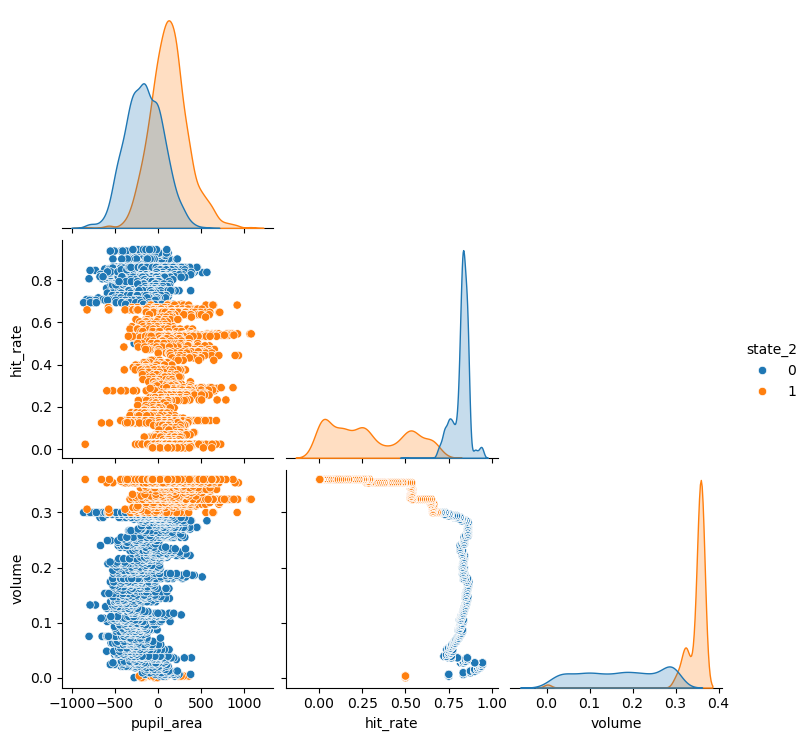

In [201]:
sns.pairplot(m_result[["pupil_area", "hit_rate", "volume", "state_2"]], corner=True, hue="state_2");

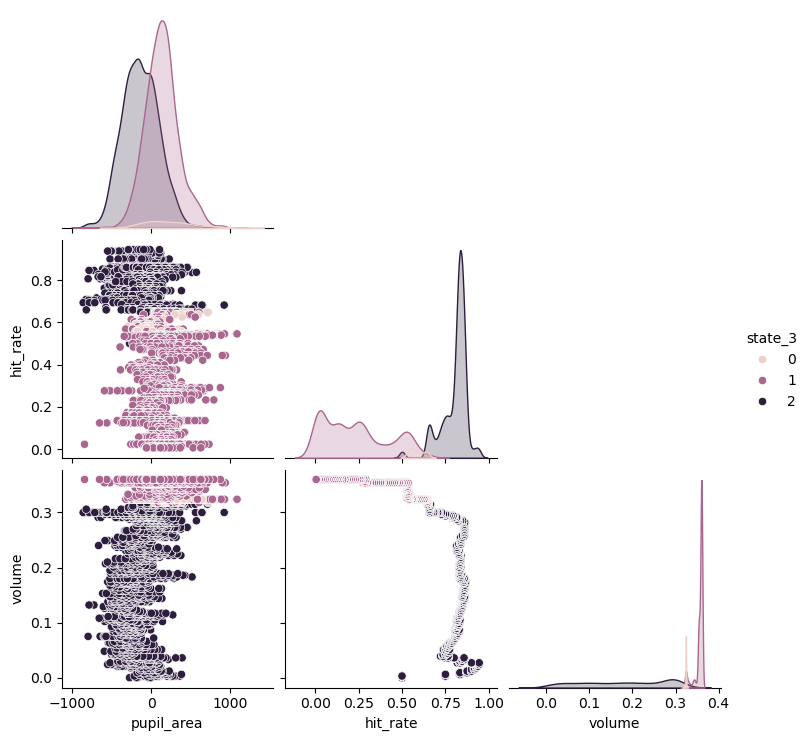

In [202]:
sns.pairplot(m_result[["pupil_area", "hit_rate", "volume", "state_3"]], corner=True, hue="state_3");

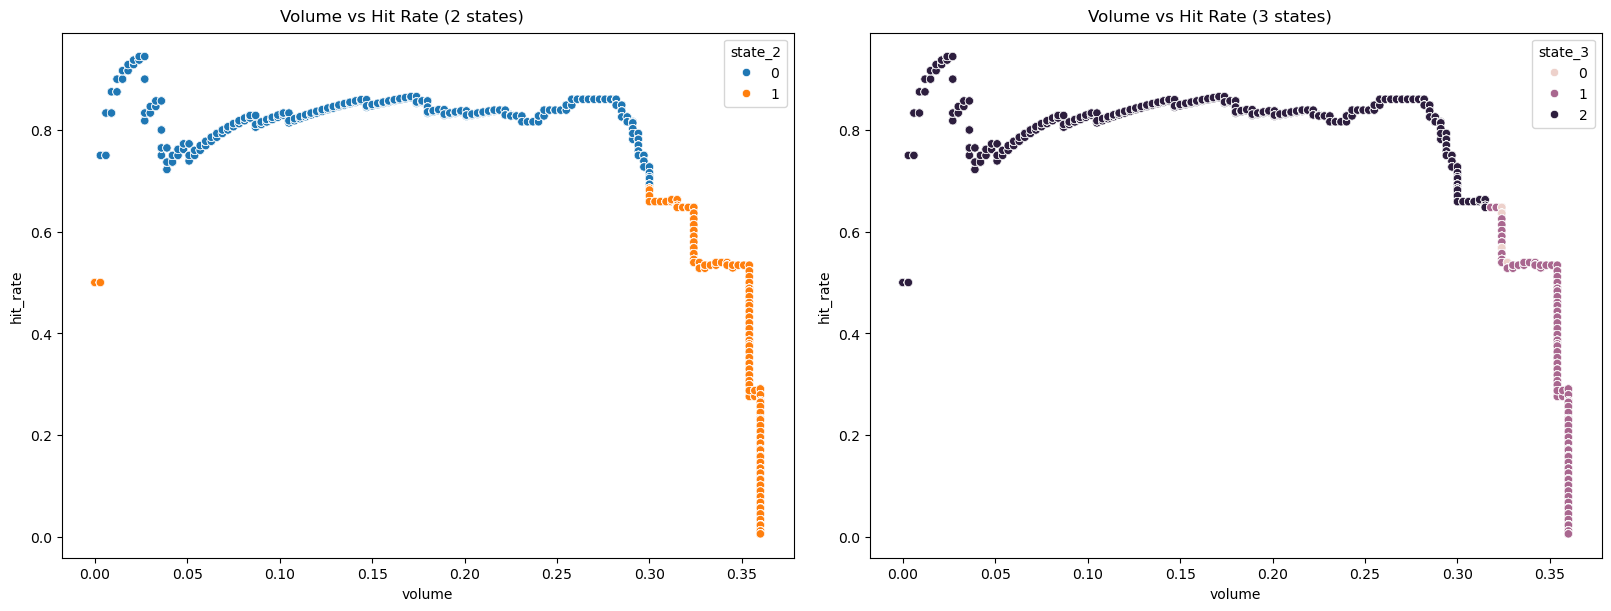

In [203]:
fig = plt.figure(constrained_layout=True, figsize=(16,6))
subfigs = fig.subfigures(nrows=1, ncols=2)
for col, subfig in enumerate(subfigs):
    state = col + 2
    subfig.suptitle(f"Volume vs Hit Rate ({state} states)")
    ax = subfig.subplots()
    sns.scatterplot(m_result, x="volume", y="hit_rate", hue=m_result[f"state_{state}"], ax=ax)

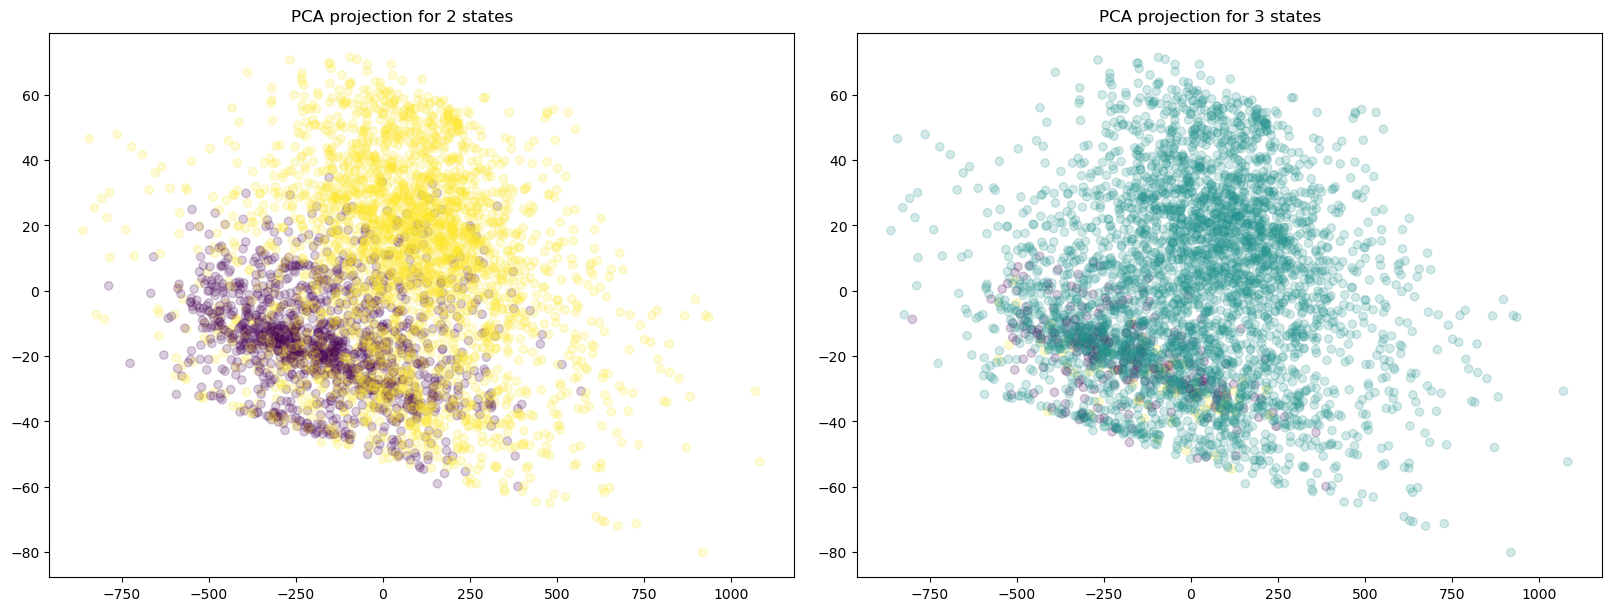

In [130]:
pca = PCA(n_components=3)
embeddings = pca.fit_transform(metrics[metric_idx])
fig = plt.figure(constrained_layout=True, figsize=(16,6))
subfigs = fig.subfigures(nrows=1, ncols=2)
for col, subfig in enumerate(subfigs):
    state = col + 2
    subfig.suptitle(f"PCA projection for {state} states")
    ax = subfig.subplots()
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=m_result[f"state_{state}"], alpha=0.2)

In [131]:
model_3.aic(metrics[metric_idx][["pupil_area", "hit_rate", "volume",]])

83016.17389099317

In [132]:
model_2.aic(metrics[metric_idx][["pupil_area", "hit_rate", "volume",]])

81012.44636029183